In [10]:
############ Imports ############

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from PIL import Image
import time

############ Initializations ############

num_classes = 10
channels = 1
height = 64
width = 64
# MNIST was resized to 64 * 64 for discriminator and generator architecture fitting
latent = 100
epsilon = 1e-7
labeled_rate = 0.2 # For initial testing

############ Importing MNIST data ############

def get_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    # Expanding the dimensions to add a channel dimension and converting to float
    train_images = np.expand_dims(train_images, axis=-1).astype('float32')
    test_images = np.expand_dims(test_images, axis=-1).astype('float32')

    # Converting labels to one-hot encoded format
    train_labels = tf.keras.utils.to_categorical(train_labels, 10)
    test_labels = tf.keras.utils.to_categorical(test_labels, 10)

    return train_images, train_labels, test_images, test_labels


                ############ Normalizing data ############
# Scaling in range (-1,1) for generator tanh output
def scale(x):
    # normalize data
    x = (x - 0.5) / 0.5
    return x

"""Discriminator and Generator architecture should mirror each other"""

############ Defining Discriminator ############

def discriminator(x, dropout_rate = 0., is_training = True, reuse = False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        print('Discriminator architecture: ')
      
        # Layer 1
        conv1 = tf.keras.layers.Conv2D(filters=128, kernel_size=[4,4], strides=[2,2], padding='same', activation=tf.nn.leaky_relu, name='conv1')(x)
        dropout1 = tf.nn.dropout(conv1, dropout_rate)
        print(conv1.shape)
      
        # Layer 2
        conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=[4,4], strides=[2,2], padding='same', activation=tf.nn.leaky_relu, name='conv2')(dropout1)
        batch2 = tf.keras.layers.BatchNormalization()(conv2, training=is_training)
        dropout2 = tf.nn.dropout(batch2, dropout_rate)
        print(conv2.shape)
      
        # Layer 3
        conv3 = tf.keras.layers.Conv2D(filters=512, kernel_size=[4,4], strides=[4,4], padding='same', activation=tf.nn.leaky_relu, name='conv3')(dropout2)
        batch3 = tf.keras.layers.BatchNormalization()(conv3, training=is_training)
        dropout3 = tf.nn.dropout(batch3, dropout_rate)
        print(conv3.shape)
        
        # Layer 4
        conv4 = tf.keras.layers.Conv2D(filters=1024, kernel_size=[3,3], strides=[1,1], padding='valid', activation=tf.nn.leaky_relu, name='conv4')(dropout3)
        print(conv4.shape)
      
        # Flatten and Dense Layer
        flatten = tf.reduce_mean(conv4, axis=[1, 2])
        logits_D = tf.keras.layers.Dense(1 + num_classes)(flatten)
        
        out_D = tf.nn.softmax(logits_D)
        
    return flatten, logits_D, out_D


############ Defining Generator ############

def generator(z, dropout_rate = 0., is_training = True, reuse = False):
    # input latent z -> image x

    with tf.variable_scope('Generator', reuse = reuse):
      print('\n Generator architecture: ')

      #Layer 1
      deconv1 = tf.layers.conv2d_transpose(z, 512, kernel_size = [4,4],
                                         strides = [1,1], padding = 'valid',
                                        activation = tf.nn.relu, name = 'deconv1') # ?*4*4*512
      batch1 = tf.layers.batch_normalization(deconv1, training = is_training)
      dropout1 = tf.nn.dropout(batch1, dropout_rate)
      print(deconv1.shape)

      #Layer 2
      deconv2 = tf.layers.conv2d_transpose(dropout1, 256, kernel_size = [4,4],
                                         strides = [4,4], padding = 'same',
                                        activation = tf.nn.relu, name = 'deconv2')# ?*16*16*256
      batch2 = tf.layers.batch_normalization(deconv2, training = is_training)
      dropout2 = tf.nn.dropout(batch2, dropout_rate)
      print(deconv2.shape)

      #Layer 3
      deconv3 = tf.layers.conv2d_transpose(dropout2, 128, kernel_size = [4,4],
                                         strides = [2,2], padding = 'same',
                                        activation = tf.nn.relu, name = 'deconv3')# ?*32*32*256
      batch3 = tf.layers.batch_normalization(deconv3, training = is_training)
      dropout3 = tf.nn.dropout(batch3, dropout_rate)
      print(deconv3.shape)

      #Output layer
      deconv4 = tf.layers.conv2d_transpose(dropout3, 1, kernel_size = [4,4],
                                        strides = [2,2], padding = 'same',
                                        activation = None, name = 'deconv4')# ?*64*64*1
      out = tf.nn.tanh(deconv4)
      print(deconv4.shape)

    return out

############ Building model ############

def build_GAN(x_real, z, dropout_rate, is_training):

    fake_images = generator(z, dropout_rate, is_training)

    D_real_features, D_real_logits, D_real_prob = discriminator(x_real, dropout_rate,
                                                              is_training)

    D_fake_features, D_fake_logits, D_fake_prob = discriminator(fake_images, dropout_rate,
                                                                is_training, reuse = True)
    #Setting reuse=True this time for using variables trained in real batch training

    return D_real_features, D_real_logits, D_real_prob, D_fake_features, D_fake_logits, D_fake_prob, fake_images

############ Preparing Mask ############

# Preparing a binary label_mask to be multiplied with real labels
def get_labeled_mask(labeled_rate, batch_size):
    labeled_mask = np.zeros([batch_size], dtype=np.float32)
    labeled_count = int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    np.random.shuffle(labeled_mask)
    return labeled_mask

############ Preparing Extended label ############

def prepare_extended_label(label):
    # add extra label for fake data
    extended_label = tf.concat([tf.zeros([tf.shape(label)[0], 1]), label], axis = 1)

    return extended_label

############ Defining losses ############

# The total loss inculcates  D_L_Unsupervised + D_L_Supervised + G_feature_matching loss + G_R/F loss

def loss_accuracy(D_real_features, D_real_logit, D_real_prob, D_fake_features,
                  D_fake_logit, D_fake_prob, extended_label, labeled_mask):

                    ### Discriminator loss ###

    # Supervised loss -> which class the real data belongs to

    temp = tf.nn.softmax_cross_entropy_with_logits_v2(logits = D_real_logit,
                                                  labels = extended_label)
    # Don't confuse labeled_rate with labeled_mask
    # Labeled_mask and temp are of same size = batch_size where temp is softmax
    # cross_entropy calculated over whole batch

    D_L_Supervised = tf.reduce_sum(tf.multiply(temp,labeled_mask)) / tf.reduce_sum(labeled_mask)

    # Multiplying temp with labeled_mask gives supervised loss on labeled_mask
    # data only, calculating mean by dividing by no of labeled samples

    # Unsupervised loss -> R/F

    D_L_RealUnsupervised = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_real_logit[:, 0], labels = tf.zeros_like(D_real_logit[:, 0], dtype=tf.float32)))

    D_L_FakeUnsupervised = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_fake_logit[:, 0], labels = tf.ones_like(D_fake_logit[:, 0], dtype=tf.float32)))

    D_L = D_L_Supervised + D_L_RealUnsupervised + D_L_FakeUnsupervised


                    ### Generator loss ###

    # G_L_1 -> Fake data wanna be real

    G_L_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = D_fake_logit[:, 0],labels = tf.zeros_like(D_fake_logit[:, 0], dtype=tf.float32)))

    # G_L_2 -> Feature matching
    data_moments = tf.reduce_mean(D_real_features, axis = 0)
    sample_moments = tf.reduce_mean(D_fake_features, axis = 0)
    G_L_2 = tf.reduce_mean(tf.square(data_moments-sample_moments))


    G_L = G_L_1 + G_L_2

    prediction = tf.equal(tf.argmax(D_real_prob[:, 1:], 1),
                                  tf.argmax(extended_label[:, 1:], 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

    return D_L, G_L, accuracy

############ Defining Optimizer ############

def optimizer(D_Loss, G_Loss, learning_rate, beta1):
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        all_vars = tf.trainable_variables()
        D_vars = [var for var in all_vars if var.name.startswith('Discriminator')]
        G_vars = [var for var in all_vars if var.name.startswith('Generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1,
                                             name = 'd_optimiser').minimize(D_Loss, var_list=D_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1,
                                             name = 'g_optimiser').minimize(G_Loss, var_list=G_vars)

    return d_train_opt, g_train_opt

############ Plotting Results ############

def show_result(test_images, num_epoch, show = True, save = False, path = 'result.png'):

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i in range(0, size_figure_grid):
      for j in range(0, size_figure_grid):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):


    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

############ TRAINING ############

def train_GAN(batch_size, epochs):

    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []

    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=[None, height, width, channels], name='x')
    z = tf.placeholder(tf.float32, shape=[None, 1, 1, latent], name='z')
    label = tf.placeholder(tf.float32, shape=[None, num_classes], name='label')
    labeled_mask = tf.placeholder(tf.float32, shape=[None], name='labeled_mask')
    dropout_rate = tf.placeholder(tf.float32, name='dropout_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')

    lr_rate = 2e-4

    model = build_GAN(x, z, dropout_rate, is_training)
    D_real_features, D_real_logit, D_real_prob, D_fake_features, D_fake_logit, D_fake_prob, fake_data = model

    extended_label = prepare_extended_label(label)

    # Fake_data of size = batch_size*28*28*1

    loss_acc = loss_accuracy(D_real_features, D_real_logit, D_real_prob,
                                  D_fake_features, D_fake_logit, D_fake_prob,
                                  extended_label, labeled_mask)
    D_L, G_L, accuracy = loss_acc

    D_optimizer, G_optimizer = optimizer(D_L, G_L, lr_rate, beta1 = 0.5)

    print ('...Training begins...')

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      train_images, train_labels, test_images, test_labels = get_data()
      no_of_batches = int(train_images.shape[0] / batch_size)

      for epoch in range(epochs):

        train_accuracies, train_D_losses, train_G_losses = [], [], []
            # Shuffle dataset at the beginning of each epoch
        indices = np.arange(train_images.shape[0])
        np.random.shuffle(indices)
        shuffled_train_images = train_images[indices]
        shuffled_train_labels = train_labels[indices]
        
        # Calculate the number of batches
        no_of_batches = int(np.ceil(shuffled_train_images.shape[0] / batch_size))

        for batch_num in range(no_of_batches):

          start = batch_num * batch_size
          end = min(start + batch_size, shuffled_train_images.shape[0])

          batch_images = shuffled_train_images[start:end]
          batch_labels = shuffled_train_labels[start:end]

          # Resize images
          batch_images_resized = np.array([np.array(Image.fromarray(img.squeeze(), 'L').resize((64, 64))) for img in batch_images])
          batch_images_resized = np.expand_dims(batch_images_resized, axis=-1)

          # Normalize images
          batch_images_normalized = scale(batch_images_resized)

          # Generate random noise for generator
          batch_z = np.random.normal(0, 1, (batch_images_resized.shape[0], 1, 1, latent))

          # Create mask for labeled data
          mask = get_labeled_mask(labeled_rate, batch_images_resized.shape[0])

          # Create feed dictionary
          train_feed_dict = {
              x: batch_images_normalized,
              z: batch_z,
              label: batch_labels,
              labeled_mask: mask,
              dropout_rate: 0.7,
              is_training: True
          }
          #The label provided in dict are one hot encoded in 10 classes

          D_optimizer.run(feed_dict = train_feed_dict)
          G_optimizer.run(feed_dict = train_feed_dict)

          train_D_loss = D_L.eval(feed_dict = train_feed_dict)
          train_G_loss = G_L.eval(feed_dict = train_feed_dict)
          train_accuracy = accuracy.eval(feed_dict = train_feed_dict)

          train_D_losses.append(train_D_loss)
          train_G_losses.append(train_G_loss)
          train_accuracies.append(train_accuracy)
          print('Batch evaluated: ' +str(batch_num+1))

        tr_GL = np.mean(train_G_losses)
        tr_DL = np.mean(train_D_losses)
        tr_acc = np.mean(train_accuracies)

        print ('After epoch: '+ str(epoch+1) + ' Generator loss: '
                       + str(tr_GL) + ' Discriminator loss: ' + str(tr_DL) + ' Accuracy: ' + str(tr_acc))

        gen_samples = fake_data.eval(feed_dict = {z : np.random.normal(0, 1, (25, 1, 1, latent)), dropout_rate : 0.7, is_training : False})
        # Dont train batch-norm while plotting => is_training = False
        test_images = tf.image.resize_images(gen_samples, [64, 64]).eval()
        show_result(test_images, (epoch + 1), show = True, save = False, path = '')

        train_hist['D_losses'].append(np.mean(train_D_losses))
        train_hist['G_losses'].append(np.mean(train_G_losses))

      show_train_hist(train_hist, show=True, save = True, path = 'train_hist.png')
      sess.close()

    return train_D_losses,train_G_losses

key = train_GAN( 4 , 5)


 Generator architecture: 
(?, 4, 4, 512)
(?, 16, 16, 256)
(?, 32, 32, 128)
(?, 64, 64, 1)
Discriminator architecture: 
(?, 32, 32, 128)


C:\Users\vivia\AppData\Local\Temp\ipykernel_23464\3344923908.py:92: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  deconv1 = tf.layers.conv2d_transpose(z, 512, kernel_size = [4,4],
C:\Users\vivia\AppData\Local\Temp\ipykernel_23464\3344923908.py:95: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  batch1 = tf.layers.batch_normalization(deconv1, training = is_training)
C:\Users\vivia\AppData\Local\Temp\ipykernel_23464\3344923908.py:100: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  deconv2 = tf.layers.conv2d_transpose(drop

(?, 16, 16, 256)
(?, 4, 4, 512)
(?, 2, 2, 1024)
Discriminator architecture: 
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 4, 4, 512)
(?, 2, 2, 1024)
...Training begins...
Batch evaluated: 1
Batch evaluated: 2
Batch evaluated: 3
Batch evaluated: 4
Batch evaluated: 5
Batch evaluated: 6
Batch evaluated: 7
Batch evaluated: 8
Batch evaluated: 9
Batch evaluated: 10
Batch evaluated: 11
Batch evaluated: 12
Batch evaluated: 13
Batch evaluated: 14
Batch evaluated: 15
Batch evaluated: 16
Batch evaluated: 17
Batch evaluated: 18
Batch evaluated: 19
Batch evaluated: 20
Batch evaluated: 21
Batch evaluated: 22
Batch evaluated: 23
Batch evaluated: 24
Batch evaluated: 25
Batch evaluated: 26
Batch evaluated: 27
Batch evaluated: 28
Batch evaluated: 29
Batch evaluated: 30
Batch evaluated: 31
Batch evaluated: 32
Batch evaluated: 33
Batch evaluated: 34
Batch evaluated: 35
Batch evaluated: 36
Batch evaluated: 37
Batch evaluated: 38
Batch evaluated: 39
Batch evaluated: 40
Batch evaluated: 41
Batch evaluated: 42
Batch

KeyboardInterrupt: 

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Reshape, Dense  # Add more layers as per your GAN architecture
from tensorflow.keras.models import Model

def build_GAN():
    # Build your GAN architecture here
    # This is a placeholder architecture. Replace with your actual models.
    # Example Generator
    z = Input(shape=(latent,))
    gen = Dense(128, activation='relu')(z)
    gen = Dense(784, activation='sigmoid')(gen)
    gen = Reshape((28, 28, 1))(gen)
    generator = Model(z, gen)

    # Example Discriminator
    x = Input(shape=(28, 28, 1))
    disc = Dense(128, activation='relu')(x)
    disc = Dense(1, activation='sigmoid')(disc)
    discriminator = Model(x, disc)

    return generator, discriminator

def train_GAN(batch_size, epochs):
    # Initialize GAN components
    generator, discriminator = build_GAN()
    # Optimizers
    gen_optimizer = tf.optimizers.Adam(2e-4)
    disc_optimizer = tf.optimizers.Adam(2e-4)

    # Training history
    train_hist = {'D_losses': [], 'G_losses': []}

    # Load and preprocess MNIST data
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)

    for epoch in range(epochs):
        for i in range(0, x_train.shape[0], batch_size):
            batch_images = x_train[i:i + batch_size]

            # Sample random noise for G
            noise = np.random.normal(0, 1, size=(batch_size, latent))

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate images
                generated_images = generator(noise, training=True)

                # Discriminator output
                real_output = discriminator(batch_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                # Calculate loss
                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            # Gradient updates
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            print(f"Epoch {epoch + 1}, Batch {i // batch_size + 1}, G Loss: {gen_loss}, D Loss: {disc_loss}")

            # Save losses for history
            train_hist['D_losses'].append(disc_loss.numpy())
            train_hist['G_losses'].append(gen_loss.numpy())

        # Display or save generated images per epoch

    # Display training history
    # show_train_hist(train_hist, show=True, save=True, path='train_hist.png')

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Set parameters
batch_size = 64
epochs = 10
latent = 100  # Update as per your latent dimension

# Train the GAN
train_GAN(batch_size, epochs)


C:\Users\vivia\anaconda3\Lib\site-packages\keras\src\backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1, Batch 1, G Loss: Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32), D Loss: Tensor("add_3:0", shape=(), dtype=float32)


AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Reshape, Dense  # Add more layers as per your GAN architecture
from tensorflow.keras.models import Model

def build_GAN():
    # Build your GAN architecture here
    # This is a placeholder architecture. Replace with your actual models.
    # Example Generator
    z = Input(shape=(latent,))
    gen = Dense(128, activation='relu')(z)
    gen = Dense(784, activation='sigmoid')(gen)
    gen = Reshape((28, 28, 1))(gen)
    generator = Model(z, gen)

    # Example Discriminator
    x = Input(shape=(28, 28, 1))
    disc = Dense(128, activation='relu')(x)
    disc = Dense(1, activation='sigmoid')(disc)
    discriminator = Model(x, disc)

    return generator, discriminator

def train_GAN(batch_size, epochs):
    # Initialize GAN components
    generator, discriminator = build_GAN()
    # Optimizers
    gen_optimizer = tf.optimizers.Adam(2e-4)
    disc_optimizer = tf.optimizers.Adam(2e-4)

    # Training history
    train_hist = {'D_losses': [], 'G_losses': []}

    # Load and preprocess MNIST data
    (x_train, y_train), (_, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)

    for epoch in range(epochs):
        for i in range(0, x_train.shape[0], batch_size):
            batch_images = x_train[i:i + batch_size]

            # Sample random noise for G
            noise = np.random.normal(0, 1, size=(batch_size, latent))

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate images
                generated_images = generator(noise, training=True)

                # Discriminator output
                real_output = discriminator(batch_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                # Calculate loss
                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            # Gradient updates
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            print(f"Epoch {epoch + 1}, Batch {i // batch_size + 1}, G Loss: {gen_loss}, D Loss: {disc_loss}")

            # Save losses for history
            train_hist['D_losses'].append(disc_loss.numpy())
            train_hist['G_losses'].append(gen_loss.numpy())

        # Display or save generated images per epoch

    # Display training history
    # show_train_hist(train_hist, show=True, save=True, path='train_hist.png')

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Set parameters
batch_size = 64
epochs = 10
latent = 100  # Update as per your latent dimension

# Train the GAN
train_GAN(batch_size, epochs)


Epoch 1, Batch 1, G Loss: Tensor("binary_crossentropy_3/weighted_loss/value:0", shape=(), dtype=float32), D Loss: Tensor("add_7:0", shape=(), dtype=float32)


AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

Epoch 1/50
3/3 [==============================] - 1s 136ms/step - loss: 2.5229 - accuracy: 0.1111 - val_loss: 2.2731 - val_accuracy: 0.1000
Epoch 2/50
3/3 [==============================] - 0s 29ms/step - loss: 2.1526 - accuracy: 0.2000 - val_loss: 2.1746 - val_accuracy: 0.2000
Epoch 3/50
3/3 [==============================] - 0s 28ms/step - loss: 2.0018 - accuracy: 0.3333 - val_loss: 1.9099 - val_accuracy: 0.3000
Epoch 4/50
3/3 [==============================] - 0s 30ms/step - loss: 1.8145 - accuracy: 0.3111 - val_loss: 1.6560 - val_accuracy: 0.4000
Epoch 5/50
3/3 [==============================] - 0s 30ms/step - loss: 1.6596 - accuracy: 0.4222 - val_loss: 1.4745 - val_accuracy: 0.6000
Epoch 6/50
3/3 [==============================] - 0s 29ms/step - loss: 1.4929 - accuracy: 0.4667 - val_loss: 1.3841 - val_accuracy: 0.6000
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 1.3697 - accuracy: 0.5667 - val_loss: 1.2766 - val_accuracy: 0.6000
Epoch 8/50
3/3 [==========

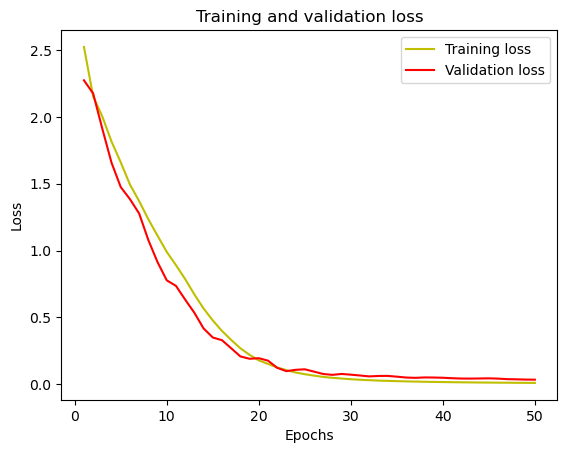

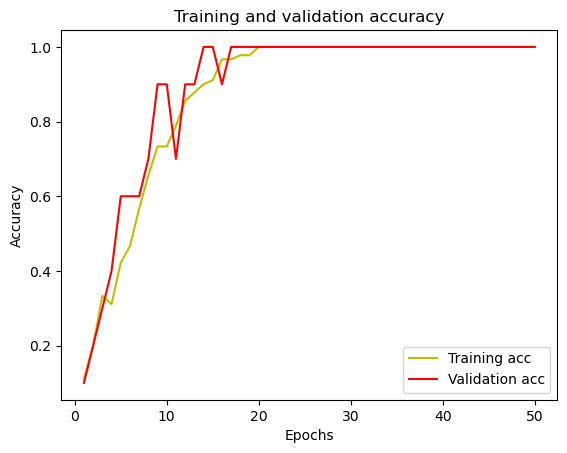

Epoch 1, Generator Loss: 0.33322879672050476, Discriminator Loss: 2.5512633323669434, Time: 59.903911113739014 sec


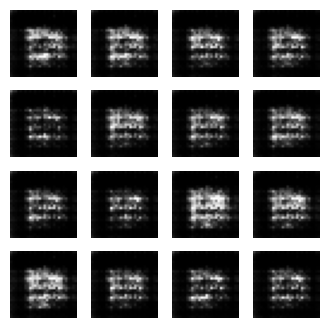

Epoch 2, Generator Loss: 0.6028110980987549, Discriminator Loss: 1.6068027019500732, Time: 55.42499351501465 sec


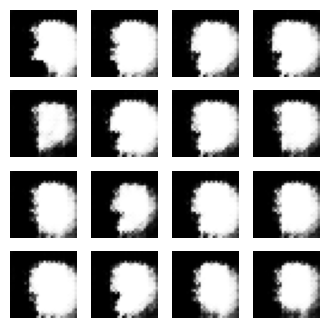

Epoch 3, Generator Loss: 0.6899130940437317, Discriminator Loss: 1.474354863166809, Time: 57.89123606681824 sec


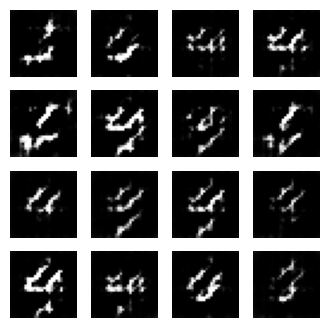

Epoch 4, Generator Loss: 0.6632910966873169, Discriminator Loss: 1.4913427829742432, Time: 56.94115877151489 sec


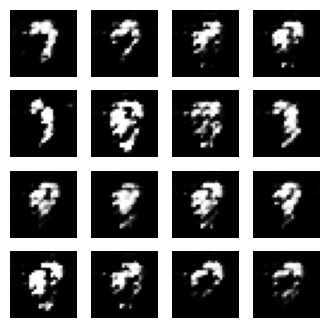

Epoch 5, Generator Loss: 0.6684407591819763, Discriminator Loss: 1.4701496362686157, Time: 57.89190077781677 sec


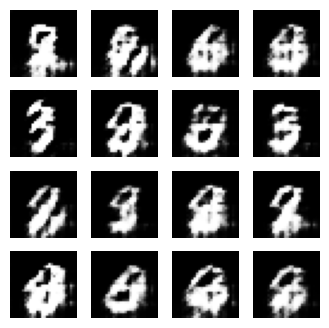

Epoch 6, Generator Loss: 0.6709519028663635, Discriminator Loss: 1.5037556886672974, Time: 56.42790627479553 sec


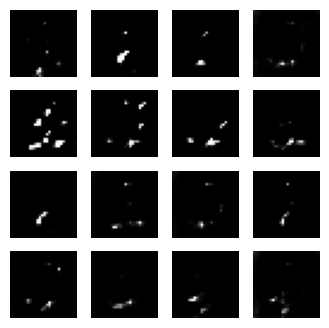

Epoch 7, Generator Loss: 0.7063681483268738, Discriminator Loss: 1.4205607175827026, Time: 58.11708045005798 sec


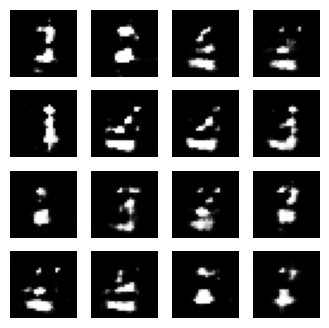

Epoch 8, Generator Loss: 0.6804179549217224, Discriminator Loss: 1.454040288925171, Time: 58.37653303146362 sec


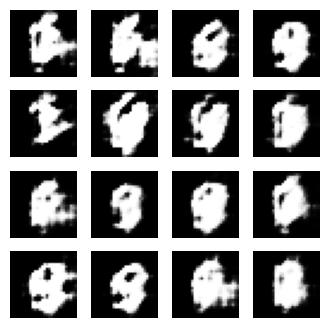

Epoch 9, Generator Loss: 0.6667301058769226, Discriminator Loss: 1.4698853492736816, Time: 57.91616439819336 sec


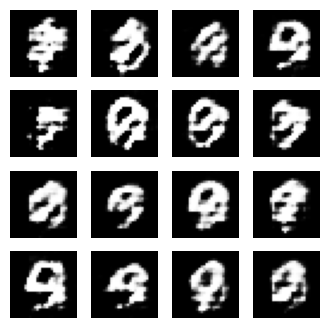

Epoch 10, Generator Loss: 0.6992632746696472, Discriminator Loss: 1.4077550172805786, Time: 58.152289152145386 sec


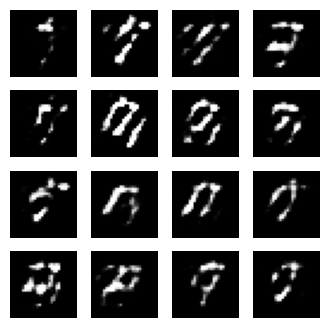

Epoch 11, Generator Loss: 0.685369074344635, Discriminator Loss: 1.4288520812988281, Time: 57.98419737815857 sec


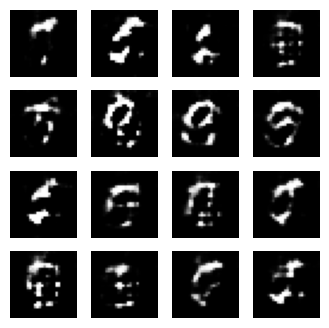

Epoch 12, Generator Loss: 0.6961153745651245, Discriminator Loss: 1.4103829860687256, Time: 58.0582914352417 sec


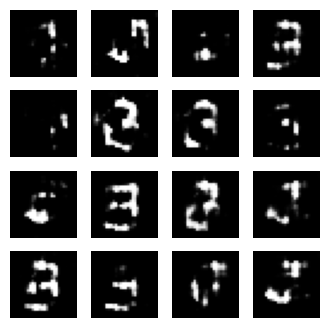

Epoch 13, Generator Loss: 0.6940975189208984, Discriminator Loss: 1.410281777381897, Time: 57.80293846130371 sec


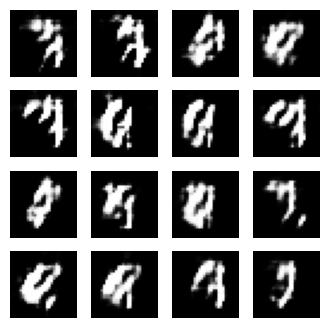

Epoch 14, Generator Loss: 0.7002437114715576, Discriminator Loss: 1.3938429355621338, Time: 59.79574728012085 sec


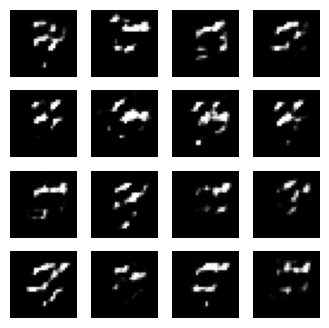

Epoch 15, Generator Loss: 0.7121743559837341, Discriminator Loss: 1.3884817361831665, Time: 58.0146222114563 sec


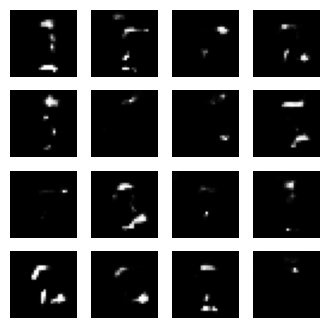

Epoch 16, Generator Loss: 0.702996551990509, Discriminator Loss: 1.419127106666565, Time: 58.04870080947876 sec


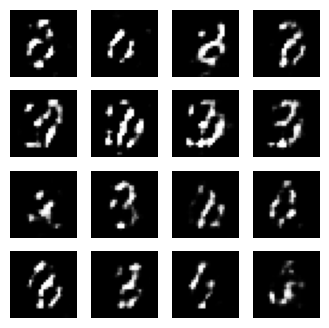

Epoch 17, Generator Loss: 0.7119925022125244, Discriminator Loss: 1.3657156229019165, Time: 58.279216289520264 sec


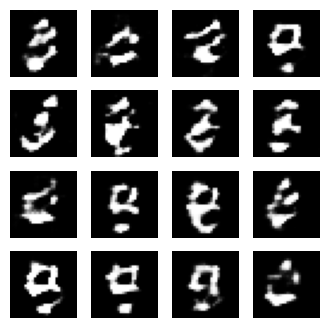

Epoch 18, Generator Loss: 0.7441866993904114, Discriminator Loss: 1.3372244834899902, Time: 58.59579586982727 sec


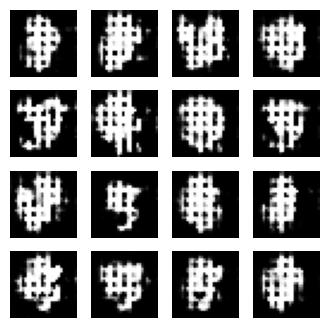

Epoch 19, Generator Loss: 0.7110316753387451, Discriminator Loss: 1.3909409046173096, Time: 57.82756280899048 sec


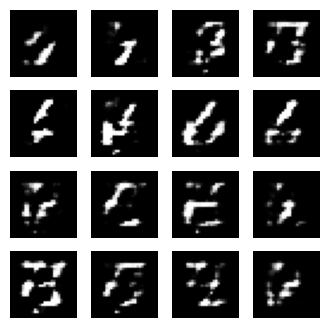

Epoch 20, Generator Loss: 0.7205518484115601, Discriminator Loss: 1.3695489168167114, Time: 58.4750657081604 sec


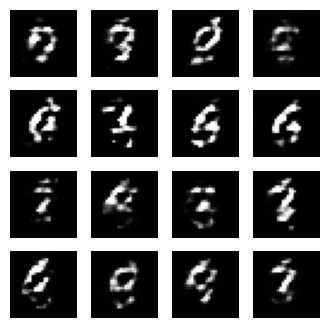

Epoch 21, Generator Loss: 0.7316862940788269, Discriminator Loss: 1.3503254652023315, Time: 58.24811816215515 sec


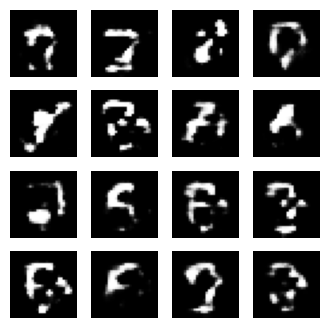

Epoch 22, Generator Loss: 0.7110874652862549, Discriminator Loss: 1.3770396709442139, Time: 60.45273232460022 sec


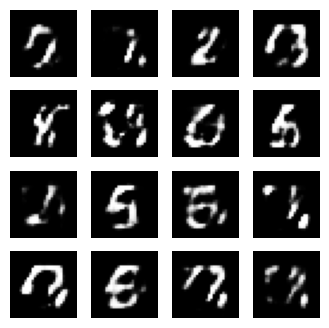

Epoch 23, Generator Loss: 0.7351110577583313, Discriminator Loss: 1.3340201377868652, Time: 58.98486590385437 sec


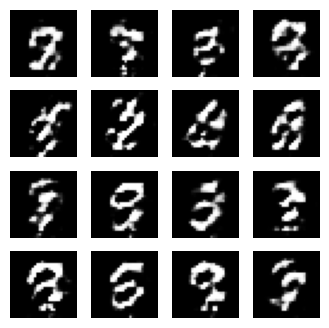

Epoch 24, Generator Loss: 0.7389352917671204, Discriminator Loss: 1.33815336227417, Time: 55.65188407897949 sec


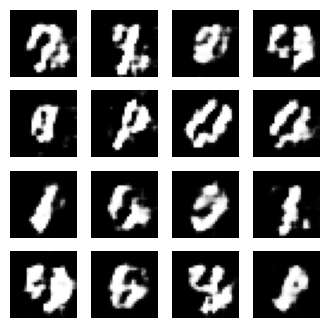

Epoch 25, Generator Loss: 0.7322596907615662, Discriminator Loss: 1.3476099967956543, Time: 57.157106161117554 sec


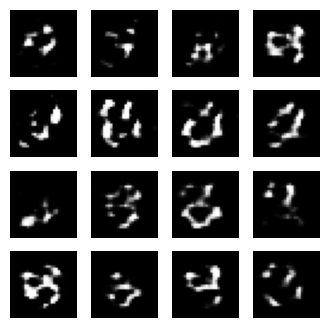

Epoch 26, Generator Loss: 0.732377827167511, Discriminator Loss: 1.3666729927062988, Time: 58.24524545669556 sec


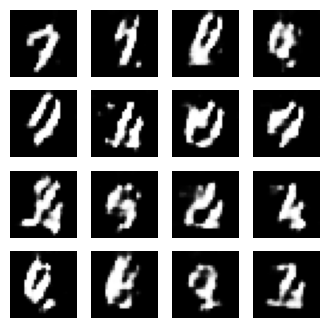

Epoch 27, Generator Loss: 0.7581104040145874, Discriminator Loss: 1.3097383975982666, Time: 60.22389888763428 sec


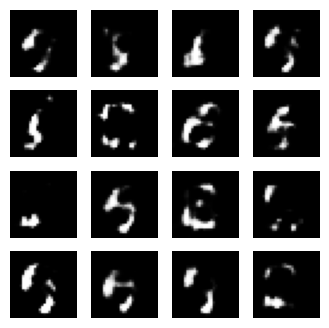

Epoch 28, Generator Loss: 0.7477649450302124, Discriminator Loss: 1.324366807937622, Time: 59.532392501831055 sec


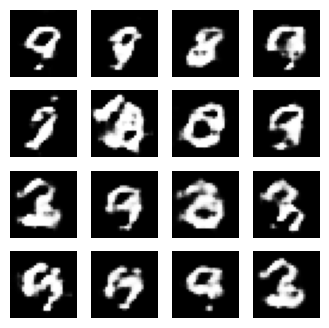

Epoch 29, Generator Loss: 0.7722935080528259, Discriminator Loss: 1.3055615425109863, Time: 59.41135215759277 sec


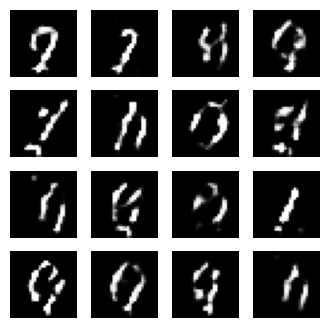

Epoch 30, Generator Loss: 0.7638128995895386, Discriminator Loss: 1.2980201244354248, Time: 58.84613871574402 sec


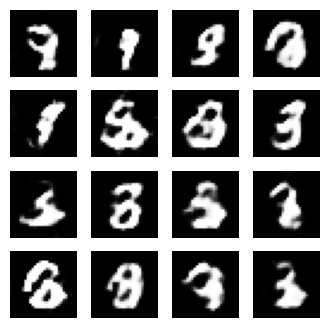

Epoch 31, Generator Loss: 0.7562160491943359, Discriminator Loss: 1.3064017295837402, Time: 62.17798471450806 sec


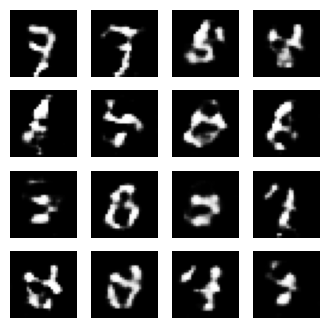

Epoch 32, Generator Loss: 0.8143272995948792, Discriminator Loss: 1.2296373844146729, Time: 60.58797740936279 sec


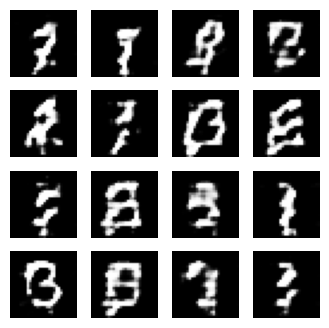

Epoch 33, Generator Loss: 0.7939105033874512, Discriminator Loss: 1.2764203548431396, Time: 59.77920150756836 sec


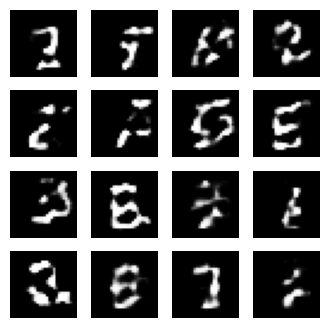

Epoch 34, Generator Loss: 0.7882495522499084, Discriminator Loss: 1.276023268699646, Time: 60.89742136001587 sec


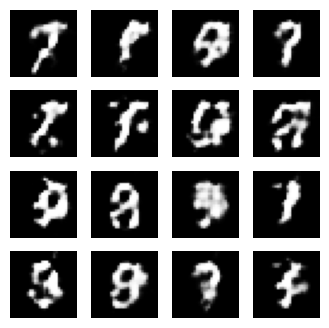

Epoch 35, Generator Loss: 0.8037034869194031, Discriminator Loss: 1.263329029083252, Time: 59.117093324661255 sec


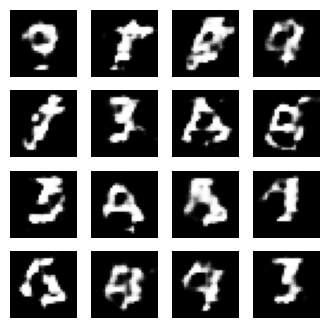

Epoch 36, Generator Loss: 0.8464768528938293, Discriminator Loss: 1.230873942375183, Time: 61.153132915496826 sec


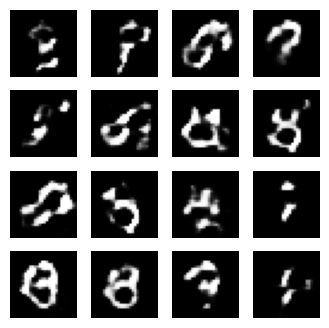

Epoch 37, Generator Loss: 0.807822048664093, Discriminator Loss: 1.2697842121124268, Time: 60.31671929359436 sec


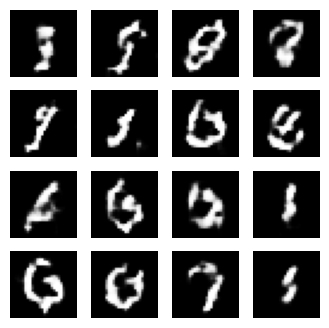

Epoch 38, Generator Loss: 0.8320311307907104, Discriminator Loss: 1.2480889558792114, Time: 58.78936958312988 sec


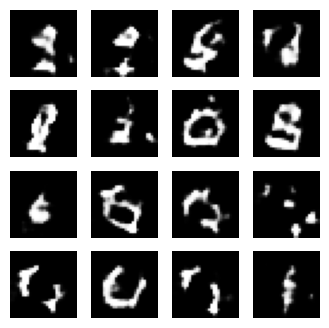

Epoch 39, Generator Loss: 0.8437739014625549, Discriminator Loss: 1.2383784055709839, Time: 58.642863750457764 sec


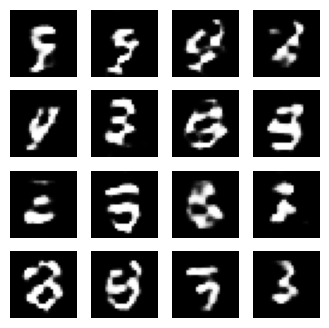

Epoch 40, Generator Loss: 0.837054967880249, Discriminator Loss: 1.2383630275726318, Time: 58.25391364097595 sec


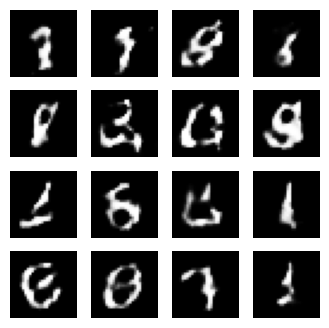

Epoch 41, Generator Loss: 0.8182331323623657, Discriminator Loss: 1.2721562385559082, Time: 58.56537055969238 sec


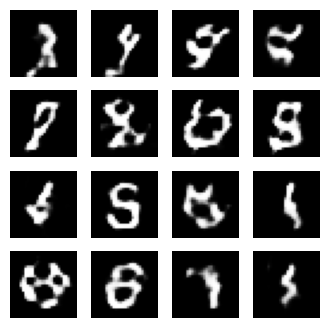

Epoch 42, Generator Loss: 0.7854011058807373, Discriminator Loss: 1.2947139739990234, Time: 59.533244371414185 sec


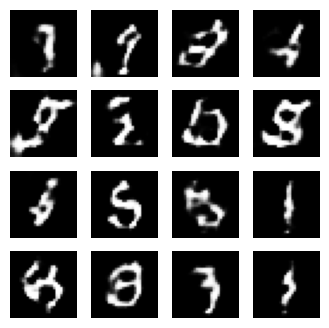

Epoch 43, Generator Loss: 0.7622559666633606, Discriminator Loss: 1.3231123685836792, Time: 58.1965811252594 sec


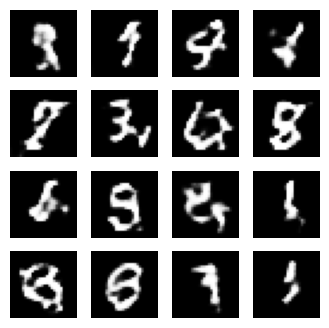

Epoch 44, Generator Loss: 0.7737669348716736, Discriminator Loss: 1.3024951219558716, Time: 58.5250244140625 sec


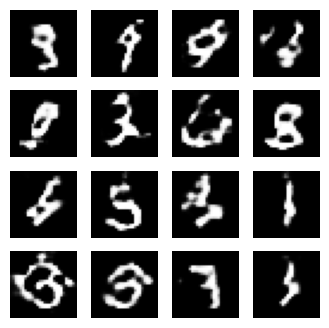

Epoch 45, Generator Loss: 0.7731190919876099, Discriminator Loss: 1.3093117475509644, Time: 58.19753694534302 sec


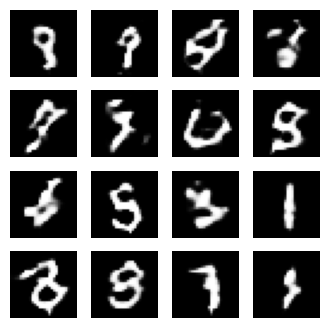

Epoch 46, Generator Loss: 0.7771502733230591, Discriminator Loss: 1.3039660453796387, Time: 58.054362535476685 sec


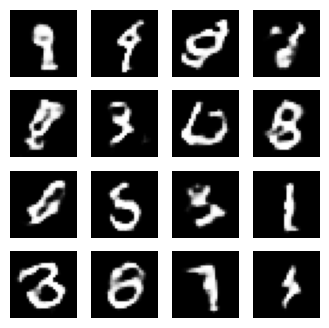

Epoch 47, Generator Loss: 0.7860164642333984, Discriminator Loss: 1.2859667539596558, Time: 60.05704426765442 sec


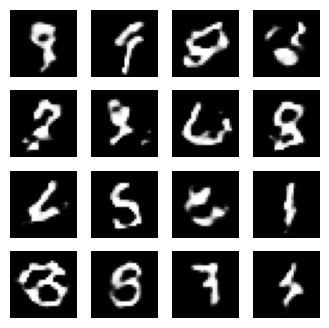

Epoch 48, Generator Loss: 0.7874139547348022, Discriminator Loss: 1.296921968460083, Time: 61.83231043815613 sec


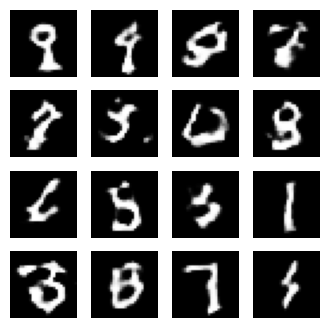

Epoch 49, Generator Loss: 0.787707507610321, Discriminator Loss: 1.2888119220733643, Time: 60.63426184654236 sec


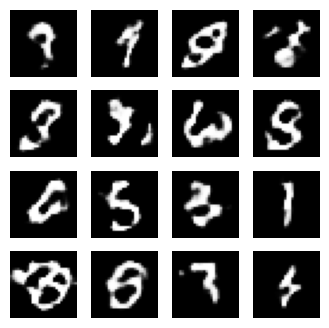

Epoch 50, Generator Loss: 0.8047989010810852, Discriminator Loss: 1.2689611911773682, Time: 61.99885654449463 sec


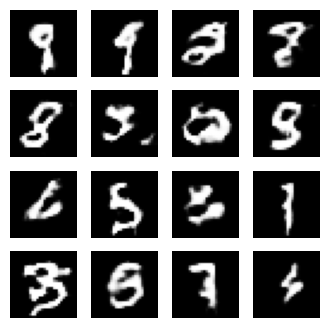

313/313 - 1s - loss: 266.6701 - accuracy: 0.1624 - 1s/epoch - 3ms/step

Supervised model test accuracy: 0.1624000072479248


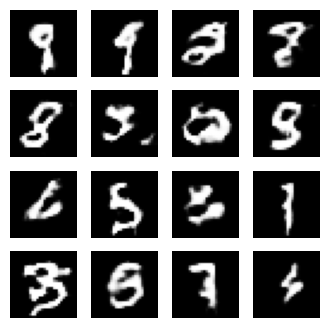

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import time

# Load and preprocess the MNIST dataset
def load_data():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5  # Normalize images to [-1, 1]
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_data()

# Build and train a supervised model
def build_supervised_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),  # Add an input layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10)
    ])
    return model

supervised_model = build_supervised_model()
supervised_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train with a small subset of data
small_train_images = train_images[:100]
small_train_labels = train_labels[:100]
history = supervised_model.fit(small_train_images, small_train_labels, epochs=50, validation_split=0.1)

# Corrected code for plotting
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

     
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Build the generator model
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),  # Add an input layer
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Build the discriminator model
def build_discriminator(supervised_model):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28, 28, 1)))  # Add an input layer

    # Use supervised model for feature extraction
    for layer in supervised_model.layers[:-1]:  # Exclude the last dense layer
        model.add(layer)

    # Add new layers for binary classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = build_generator()
discriminator = build_discriminator(supervised_model)

# Define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training loop
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for visualizing progress
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Generate and display images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train_gan(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        print(f'Epoch {epoch + 1}, Generator Loss: {np.mean(epoch_gen_loss)}, Discriminator Loss: {np.mean(epoch_disc_loss)}, Time: {time.time() - start} sec')
        
        # Generate and save images after each epoch
        generate_and_save_images(generator, epoch + 1, seed)

# Prepare dataset for GAN training
BUFFER_SIZE = 60000
BATCH_SIZE = 256  # Adjusted batch size
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Start GAN training
train_gan(train_dataset, EPOCHS)

# Evaluate supervised model on test data
test_loss, test_acc = supervised_model.evaluate(test_images, test_labels, verbose=2)
print(f'\nSupervised model test accuracy: {test_acc}')

# Generate and display images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

generate_and_save_images(generator, EPOCHS, seed)
